# 1D Heat Conduction Using PINNs

## Theoretical Background

### Problem Statement

Let us consider an Aluminum rod of length $L = 0.5 \ m$, width $w = 1\ cm$ and thermal conductivity $k = 225 \ W/m.K$. Since we are considering a 1D heat conduction, we will assume that the rod has unit depth. The left side of the wall is at a constant temperature of $100 \degree C$ (Dirichlet boundary condition). The top, bottom and right surfaces of the rod are exposed to the air at a temperature of $T_{\infty} = 10 \degree C$, with a convective heat transfer coefficient of $h = 25\ W/m^2.K$. We wish to compute the temperature profile within this rod. We will solve this using a simple PINN model and validate the result using the well know FDM technique. Let us first look into the governing equations and derive the expressions for solving them using FDM and PINNs. 


### Governing Equations

#### Left Boundary :
As mentioned in the problem statement, we have a simple Dirichlet boundary condition at the left boundary. We will conside the left most cell to be a half cell such that the cell node sits on the left wall. Thus, we have a simple equation:

$$
\boxed{
\begin{align}
%%
\nonumber T_0 &= T_{wall}
%%
\end{align}
}
$$


#### Interior Points 

For any interior point, the energy conservation equations states that the net flow of heat into the cell must be equal to the net flow of heat out of the cell. Heat flow due to conduction is give by Fourier's law: $ \dot Q_{cond} = -k A \nabla T $. The heat flow due to convection is given by Newtons law of cooling: $\dot Q_{conv} = h A (T - T_{\infty})$. In the given problem statement, for any cell, the heat flowing into the cell is due to conduction, while the outflow is due to both conduction into the next cell and convection to the ambient air. Thus, we can write the energy conservation equation as follows:

$$
\begin{align}
\nonumber \dot Q_{in-cond} &= \dot Q_{out-cond} + \dot Q_{out-conv} \\[10 pt]
%%
\nonumber -k A_{cs} \frac{dT}{dx} &= -k A_{cs} \frac{dT}{dx} + 2 h A_s (T_i - T_{\infty}) \\[10 pt]
%%
\nonumber - k (w \times 1) \left( \frac{T_i - T_{i-1}}{\Delta x} \right) &= - k (w \times 1) \left( \frac{T_{i+1} - T_i}{\Delta x} \right) + 2 h (\Delta x \times 1) (T_i - T_{\infty}) \\[10 pt]
%%
\nonumber k w \left( \frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x} \right) &= 2 h \Delta x (T_i - T_{\infty}) \\[10pt]
%%
\nonumber \alpha (T_{i-1} - 2 T_i + T_{i+1}) &= 2 \beta_{1} (T_i - T_{\infty})
%%
\end{align}
$$

$$
\boxed{
\begin{align}
\nonumber \alpha T_{i-1} - 2 (\alpha + \beta_{1}) T_i + \alpha T_{i+1} &= - 2 \beta_{1} T_{\infty}
\end{align}
}
$$


**Note :** 
- Our rod is discretized into $N$ cells, wherein the left and right most cells are half cells. Thus we will have a total of $N+1$ nodes: $i \in [0, N]$. Thus, above equation for interior points corresponds to $i \in [1, N-1]$. 
- In the above derivation, $A_{cs}$ represents the cross-sectional area and $A_{s}$ represents the area of the top and bottom surface of a cell. As we are considering 1D flow, we will assume the depth to be unity, thus:
    - $A_{cs} = (w \times 1)$
    - $ A_{s} = (\Delta x \times 1)$. 
- For brevity, we will club some of the varibles as:
    - $ \alpha = k w / \Delta x $
    - $ \beta_{1} = h \Delta x $
    - $ \beta_{2} = h w $


#### Right Boundary

At the right boundary, we again consider half cell, such that the cell node sits on the right boundary surface. This half cell ($N$) recieves heat through conduction from the previous cell ($N-1$). It loses heat through convection from its top, bottom and right surface. The energy conservation equation is derived below:

$$
\begin{align}
\nonumber Q_{in-cond} &= Q_{out-conv-right} + Q_{out-conv-top} + Q_{out-conv-bottom} \\[10pt]
%%
\nonumber -k A_{cs} \frac{dT}{dx} &= h A_{cs} (T_N - T_{\infty}) + h \frac{A_s}{2} (T_N - T_{\infty}) + h \frac{A_s}{2} (T_N - T_{\infty}) \\[10pt]
%%
\nonumber -k w \left( \frac{T_N - T_{N-1}}{\Delta x} \right) &= h w (T_N - T_{\infty}) + h \Delta x (T_N - T_{\infty}) \\[10pt]
%%
\nonumber -\alpha ( T_N - T_{N-1} ) &= \beta_{1}( T_N - T_{\infty} ) + \beta_{2}( T_N - T_{\infty} )
%%
\end{align}
$$

$$
\boxed{
\begin{align}
\nonumber \alpha T_{N-1} -(\alpha + \beta_{1} + \beta_{2}) T_N &= -(\beta_{1} + \beta_{2}) T_{\infty}
%%
\end{align}
}
$$

### Equations for FDM

Following are the equations for the left boundary, interior points and right boundary:

$$
\boxed{
\begin{align}
%%
\nonumber T_0 &= T_{wall} \\[10pt]
%%
\nonumber \alpha T_{i-1} - 2 (\alpha + \beta_{1}) T_i + \alpha T_{i+1} &= - 2 \beta_{1} T_{\infty} \ \ \ \text{( $i \in [1,\ N-1]$ )} \\[10pt]
%%
\nonumber \alpha T_{N-1} -(\alpha + \beta_{1} + \beta_{2}) T_N &= -(\beta_{1} + \beta_{2}) T_{\infty}
%%
\end{align}
}
$$


The above system of equations can be written in a matrix format and solved easily:
$$ A \times T = b \Rightarrow T = A^{-1} b $$ 
where, 
- $A$ is a $[N \times N]$ tridiagonal matrix corresponding to the coefficients of $T_i$ terms. 
- $b$ is a $[N \times 1]$ column vector corresopnding to the constants in each equation. 
- $T$ is the $[N \times 1]$ solution column vector for the temperatue $T_i$ of all the nodes.  

## Import Libraries

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


**Set device to use GPU (if available) :**

In [2]:
# # Set device (use GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu') # since the network is small, cpu will suffice
print("device :", device)


device : cpu


**Set `random.seed()` for reproducibility :**

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    print(f"torch.cuda.manual_seed_all set to : {seed}")


torch.cuda.manual_seed_all set to : 42


## Parameter Initialization

In [4]:
# Given parameters
T_wall  = 100.0     # left wall temperature [°C]
T_inf   = 10.0      # ambient temperature [°C]
L       = 0.5       # rod length [m]
k       = 225.0     # thermal conductivity [W/m.K]
h       = 25.0      # convective heat transfer coefficient [W/m^2.K]
w       = 0.01      # width of rod [m]
dx      = 0.01      # [m]


## FDM Solution

A custom function called `heat_transfer_1D_FDM()` has been created for computing the temperature profile in the rod using FDM, as per the equations derived. You can find the function in `utils_HT_1D_FDM.py`. 

In [5]:
from utils_HT_1D_FDM_v1 import heat_transfer_1D_FDM

x_fdm, T_fdm = heat_transfer_1D_FDM(T_wall, T_inf, k, h, L, w, dx)

print(f'Temperature at right boundary : {T_fdm[-1]:.2f} deg C')


Temperature at right boundary : 26.52 deg C


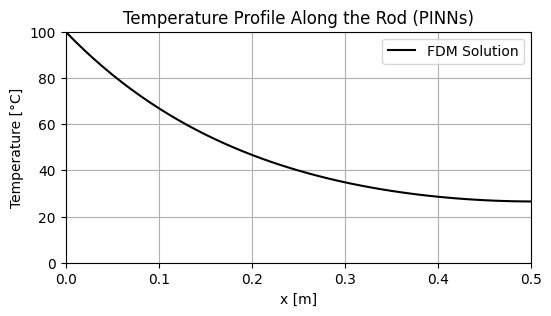

In [6]:
# Plot the temperature profile (line plot)
plt.figure(figsize=(6, 3))
plt.plot(x_fdm, T_fdm, '-k', label='FDM Solution')

plt.xlabel('x [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature Profile Along the Rod (PINNs)')
plt.axis([0, L, 0, T_wall])
plt.legend()
plt.grid(True)
plt.show()


## PINN Solution

### Generate Inputs for Training

We will use 51 uniformly distributed points along the length of the rod for training the PINN. It is generally a good idea to normalize the inputs of a neural network as it aids in training. We will use simple *min-max normalization* to normalize our input $x$ in the range $[0,\ 1]$:
$$ x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}} $$


In [7]:
# Number of points for training
num_nodes   = 51

# Create the positions as a tensor
x_coord     = torch.linspace(0, L, num_nodes, requires_grad=True, device=device).view(-1, 1)

# Normalization
x_min = min(x_coord)
x_max = max(x_coord)
x_coord_norm    = (x_coord - x_min) / (x_max - x_min)

# Input to PINN
X = x_coord
# X   = x_coord_norm


### `Class` Definition for PINN Model 

We will consider a vanilla neural network with following architecture:

**Model inputs :**
- `x_norm` : normalized position along the rod of length `L` : normalized in range [0, 1];

**Hidden Layers :**
- `3` layers; `20` neurons each; `Tanh()` activation; 

**Model output :**
- `T_norm` : temperature of the rod at location `x` : normalized in range [0, 1];


In [8]:
# Define the neural network (a simple feed-forward MLP)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, X):
        return self.net(X)


**Note :**

Using smooth activations like `Tanh` is common in PINNs because they yield smooth derivatives, which is important when computing higher-order derivatives for the PDE residual. `ReLU`, while popular in many applications, has a non-differentiable point at zero and can yield zero gradients in some regions; this might hinder training when the network needs to produce accurate second derivatives.

### `Function` for Weight Initialization of PINN Model

**Xavier normal initialization :** 

It is a weight initialization technique for neural networks that uses a normal distribution to draw weights. It aims to maintain a consistent variance of activations across layers, helping prevent vanishing or exploding gradients, particularly when using sigmoid or tanh activation functions. The weights are sampled from a normal distribution with a mean of 0 and a standard deviation determined by the number of input and output neurons in the layer. 


In [9]:
# Function for "Xavier normal initialization"
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


### Equations for PINNs Loss Function

One of the advantage of PINNs is the ability to solve the governing equations without the tedious process of discretization. This is possible because we can obtain the derivatives directly using the *automatic differentiation* ability of PyTorch using it's `torch.autograd` package. 

Now, the equations for left boundary point can be used directly as a loss function, but the equation for the interior points and right boundary need some manipulation.

#### Manipulation of Interior Points Equation

 Let us reconsider the equation interior points. Following is the equation taken from an intermediate step of its derivation (see in "Interior Points" section):

$$
\begin{align}
\nonumber k w \left( \frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x} \right) &= 2 h \Delta x (T_i - T_{\infty}) \\[10pt]
%%
\nonumber k w \left( \frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2} \right) &= 2 h (T_i - T_{\infty}) \\[10pt]
%%
\nonumber k w \frac{d^2 T_i}{d x^2} &= 2 h (T_i - T_{\infty})
%%
\end{align}
$$

$$
\boxed{
k w \frac{d^2 T_i}{d x^2} - 2 h (T_i - T_{\infty}) = 0
}
$$

Basically, the conductions terms on the LHS and RHS can be combined to yield second order derivative of temperature. This is similar to Laplase equation for heat conduction (wihout converction): $\nabla^2 T = 0$. Since we have convection occuring in the top and bottom walls, the convective term appears in the equation.


#### Manipulation of Right Boundary Point Equation
Since PINNs allows us to use the differential equation itself, without having the need to discretize, so we can consider $\Delta x \rightarrow 0$ and simplify the equation for right boundary point to:

$$
\boxed{
k \frac{dT_N}{dx} + h (T_N - T_{\infty}) = 0
}
$$

Since we are considering the actual differential equation, we do not need to create cells of finite size. Thus the convection occuring from the top and bottom surface does not need to be consider, and as such, those term vanish from the above equation. 


#### Loss Function :

Now that we have all the equations, we can define the loss function for our PINNs:
- Left Boundary Loss: 
    - $ loss_1 = [ T_0 - T_{wall} ]^2 $

- Interior Points Loss:
    - $ \displaystyle{ loss_2 = MSE \left[ k w \frac{d^2 T_i}{d x^2} - 2 h (T_i - T_{\infty}) \right] }$

- Right Boundary Loss:
    - $ \displaystyle{ loss_3 = \left[ k \frac{dT_N}{dx} + h (T_N - T_{\infty}) \right]^2 } $


## Training

### Some Theory

**Temperature De-normalization:** <br>
We will expect the PINN model to output a normalized temperature in the range $[0,\ 1]$. This will reduce training time and errors. We will consider $T_{max} = T_{wall}$ and $T_{min} = T_{\infty}$. Thus, we can de-normalize the output as follows:
$$ T = T_{norm} \times ( T_{wall} - T_{\infty} ) + T_{\infty} $$


**Learning Rate Decay :** <br>
Using large value of learning rate can help reach the minima faster. But too large a value will prevent it from converging. Thus we use learning rate decay. The value of the initial learning rate is $lr = 0.01$ and the decay rate is $\gamma = 0.9$. Learning rate is updated after every $1000$ steps. We train the model for $25000$ epochs.

**Loss Coefficients :** <br>
The magnitude of the three losses vary significantly. Thus, we multiply each of them with a coefficient `coeff_i` and then add them up for computing the total loss. This total loss is then used for backpropagated. The values of `coeff_i` have been found through trial and error.


### Training Loop

In [10]:
# Model Initialization
model = PINN().to(device)
model.apply(init_weights)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Learning-rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# oLss coefficients
coeff_1 = 1
coeff_2 = 0.1
coeff_3 = 0.01

# Number of training epochs
num_epochs = 25000

# Model training
print("#" * 17)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: predict T for all collocation points
    T_pred_norm = model(X)  # normalize output in range [0, 1]
    T_pred      = T_pred_norm*(T_wall - T_inf) + T_inf # de-normalization

    # --- Compute derivatives using autograd ---
    dTdx = torch.autograd.grad(outputs=T_pred, inputs=x_coord,
                           grad_outputs=torch.ones_like(T_pred),
                           create_graph=True)[0]
    
    
    d2Tdx2 = torch.autograd.grad(outputs=dTdx, inputs=x_coord,
                                grad_outputs=torch.ones_like(dTdx),
                                create_graph=True)[0]
    
    # --- Loss computation ---
    # 1. Left boundary:
    f_left = T_pred[0] - T_wall
    loss_left = coeff_1 * f_left**2

    # 2. Interior points: enforce PDE at interior collocation points (exclude endpoints)
    interior        = slice(1, -1)
    f_interior      = k*w*d2Tdx2[interior] - 2*h*(T_pred[interior] - T_inf)
    loss_interior   = coeff_2 * torch.mean(f_interior**2)
    
    # 3. Right boundary:
    f_right     = k*dTdx[-1] + h*(T_pred[-1] - T_inf)
    loss_right  = coeff_3 * f_right**2
    
    # Total loss
    loss_total = loss_left + loss_interior + loss_right
    loss_total.backward()
    optimizer.step()
     
    # Step the scheduler at the end of the epoch (for learning-rate dacay)
    scheduler.step()

    # Print loss for viewing progress
    if epoch == 0 or (epoch + 1) % 5000 == 0:
        print(f"Epoch {epoch+1}")
        print(f"Total Loss    = {loss_total.item():.4f}")
        print(f"Loss Left     = {loss_left.item():.4f}")
        print(f"Loss Interior = {loss_interior.item():.4f}")
        print(f"Loss Right    = {loss_right.item():.4f}")
        print("#" * 17)


#################
Epoch 1
Total Loss    = 84664.3750
Loss Left     = 8100.0000
Loss Interior = 2186.3040
Loss Right    = 74378.0703
#################
Epoch 5000
Total Loss    = 242.4380
Loss Left     = 29.1651
Loss Interior = 211.6310
Loss Right    = 1.6419
#################
Epoch 10000
Total Loss    = 3879.7974
Loss Left     = 0.0229
Loss Interior = 1583.1984
Loss Right    = 2296.5759
#################
Epoch 15000
Total Loss    = 21.4843
Loss Left     = 0.0548
Loss Interior = 21.4247
Loss Right    = 0.0048
#################
Epoch 20000
Total Loss    = 13.6750
Loss Left     = 0.0559
Loss Interior = 13.6148
Loss Right    = 0.0043
#################
Epoch 25000
Total Loss    = 11.1822
Loss Left     = 0.0530
Loss Interior = 11.1292
Loss Right    = 0.0000
#################


## Result and Visualization

### PINN Model Prediction vs FDM Solution

**PINN Model Prediction**

In [11]:
# Evaluate the trained model
with torch.no_grad():
    T_solution_norm = model(X).cpu().numpy().flatten()
    T_solution = T_solution_norm*(T_wall - T_inf) + T_inf
    x_np = x_coord.cpu().numpy().flatten()

print(f'Temperature at left boundary  : {T_solution[0]:.2f} deg C')
print(f'Temperature at right boundary : {T_solution[-1]:.2f} deg C')


Temperature at left boundary  : 99.77 deg C
Temperature at right boundary : 26.50 deg C


**FDM Solution**

In [12]:
# Import function
from utils_HT_1D_FDM_v1 import heat_transfer_1D_FDM

x_fdm, T_fdm = heat_transfer_1D_FDM(T_wall, T_inf, k, h, L, w, dx)

print(f'Temperature at right boundary : {T_fdm[0]:.2f} deg C')
print(f'Temperature at right boundary : {T_fdm[-1]:.2f} deg C')


Temperature at right boundary : 100.00 deg C
Temperature at right boundary : 26.52 deg C


### Visualization

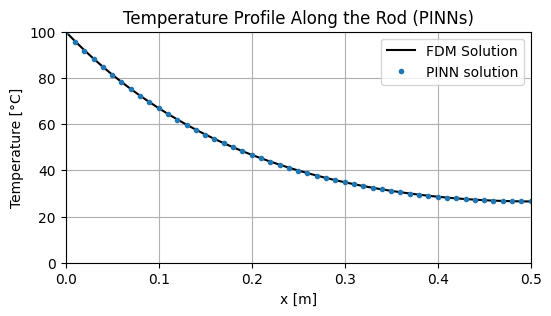

In [13]:
# Plot the temperature profile (line plot)
plt.figure(figsize=(6, 3))
plt.plot(x_fdm, T_fdm, '-k', label='FDM Solution')
plt.plot(x_np, T_solution, '.', label='PINN solution')

plt.xlabel('x [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature Profile Along the Rod (PINNs)')
plt.axis([0, L, 0, T_wall])
plt.legend()
plt.grid(True)
plt.show()
